# AE with CONV Layers

PyTorch impl of [Vid](https://www.youtube.com/watch?v=D9HjlqIrB-c)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from torch import nn

from tqdm import tqdm
from PIL import Image

from model import AutoEncoder
from constants import *

## Load Image

In [2]:
img = Image.open('../../data/mona-lisa.jpg')
img = img.resize((256, 256))
X = torch.asarray(np.asarray(img)/255, dtype=torch.float, requires_grad=True).to(device)
X = X.reshape((1,3,256,256))
X.shape

torch.Size([1, 3, 256, 256])

In [3]:
X[0][0][0][:25]

tensor([0.3765, 0.4392, 0.3373, 0.3373, 0.3843, 0.2902, 0.3529, 0.3961, 0.3020,
        0.3647, 0.4235, 0.3255, 0.3216, 0.4157, 0.3137, 0.2784, 0.4157, 0.3059,
        0.2353, 0.4000, 0.2863, 0.2314, 0.4000, 0.2980, 0.2353],
       device='cuda:0', grad_fn=<SliceBackward0>)

(256, 256, 3)

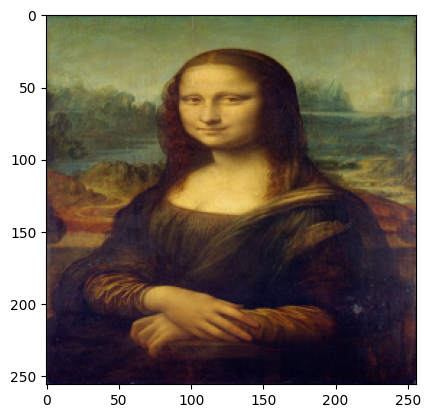

In [4]:
plt.imshow(np.array(img))
np.asarray(img).shape

## Train

In [ ]:
m = AutoEncoder().to(device)
m.forward(X)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(m.parameters(), lr=lr)

In [14]:
for i in tqdm(range(n_iters)):
    logits = m.forward(X)
    loss = criterion(logits, X)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if(i%500==0):
        print(loss)
print(loss)

  1%|          | 11/1000 [00:00<00:18, 54.29it/s]

tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 541/1000 [00:02<00:01, 238.94it/s]

tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 1000/1000 [00:04<00:00, 226.97it/s]

tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward0>)


## Test 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


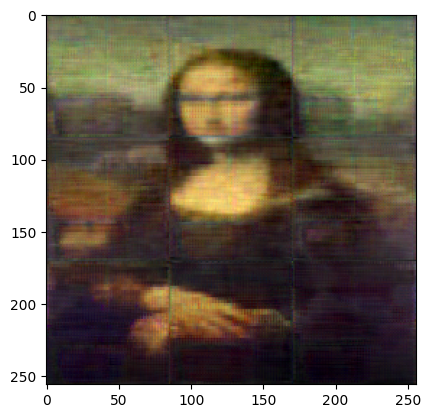

In [15]:
out = m.forward(X).reshape(1,256,256,3).cpu().detach().numpy()[0]
out =  np.array(out)
plt.imshow(out)